In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from src import constants as Con

from src.predictive_modeling.answer_correctness.answer_correctness_data import (
    build_trial_level_all_features,
)
from src.predictive_modeling.answer_correctness.answer_correctness_models import (
    MajorityBaselineCorrectness,
    AreaMetricsCorrectnessLogRegModel,
    DerivedFeaturesCorrectnessLogRegModel,
    FullFeaturesCorrectnessLogRegModel,
)
from src.predictive_modeling.answer_correctness.answer_correctness_eval import (
    evaluate_models_on_answer_correctness,
    evaluate_models_on_answer_correctness_leave_one_trial_out,
)
from src.predictive_modeling.answer_correctness.answer_correctness_viz import (
    plot_coef_summary_barh,
    show_correctness_model_results,
    plot_top_abs_coef_feature_frequency_across_participants,
    plot_top_features_by_best_avg_rank,
    compute_feature_avg_rank_across_participants,
)
from src.predictive_modeling.common.viz_utils import plot_confusion_heatmap
from src.predictive_modeling.answer_correctness.answer_correctness_viz import (
    plot_feature_correlation_heatmap,
)


In [2]:
hunters = pd.read_csv("../data/hunters.csv")
gatherers = pd.read_csv("../data/gatherers.csv")
all_participants = pd.concat([hunters, gatherers], ignore_index=True)

In [3]:
correctness_models = [
    MajorityBaselineCorrectness(),
    AreaMetricsCorrectnessLogRegModel(),
    DerivedFeaturesCorrectnessLogRegModel(),
    FullFeaturesCorrectnessLogRegModel(),
]

pref_specs = [
    (Con.MEAN_DWELL_TIME, "high"),
    (Con.MEAN_FIXATIONS_COUNT, "high"),
    (Con.MEAN_FIRST_FIXATION_DURATION, "high"),
    (Con.SKIP_RATE, "low"),
    (Con.AREA_DWELL_PROPORTION, "high"),
    (Con.MEAN_AVG_FIX_PUPIL_SIZE_Z, "high"),
    (Con.MEAN_MAX_FIX_PUPIL_SIZE_Z, "high"),
    (Con.MEAN_MIN_FIX_PUPIL_SIZE_Z, "low"),
    (Con.FIRST_ENCOUNTER_AVG_PUPIL_SIZE_Z, "high"),
    (Con.NUM_LABEL_VISITS, "high"),
    (Con.NUM_LOC_VISITS, "high"),

]


In [4]:
def build_trial_df(d: pd.DataFrame, group_cols):
    return build_trial_level_all_features(
        d,
        group_cols=group_cols,
        pref_specs=pref_specs,
    )

MODEL_NAME_FOR_ANALYSIS = "full_features_correctness_log_reg"
PAPER_DIRS = [
    "papers/correctness_prediction/figures",
]

In [5]:
results_all_corr_full = evaluate_models_on_answer_correctness(
    df=all_participants,
    models=correctness_models,
    group_cols=(Con.PARTICIPANT_ID, Con.TRIAL_ID),
    split_group_cols=[Con.PARTICIPANT_ID, Con.TRIAL_ID],
    builder_fn=build_trial_df,
)

show_correctness_model_results(results_all_corr_full)

MODEL: majority_baseline
----------------------------------------------------------------------
Number of test trials: 3887
Accuracy: 0.836
Positive (correct) trials: 3249
Negative (incorrect) trials: 638

Precision / Recall / F1 (per class):
         precision  recall    f1  support
class_0      0.000   0.000 0.000      638
class_1      0.836   1.000 0.911     3249

Averages:
  macro   P/R/F1: 0.418 / 0.500 / 0.455
  weighted P/R/F1: 0.699 / 0.836 / 0.761

MODEL: area_metrics_correctness_log_reg
----------------------------------------------------------------------
Number of test trials: 3887
Accuracy: 0.799
Positive (correct) trials: 3249
Negative (incorrect) trials: 638

Precision / Recall / F1 (per class):
         precision  recall    f1  support
class_0      0.437   0.781 0.560      638
class_1      0.949   0.803 0.870     3249

Averages:
  macro   P/R/F1: 0.693 / 0.792 / 0.715
  weighted P/R/F1: 0.865 / 0.799 / 0.819

MODEL: derived_features_correctness_log_reg
-----------------

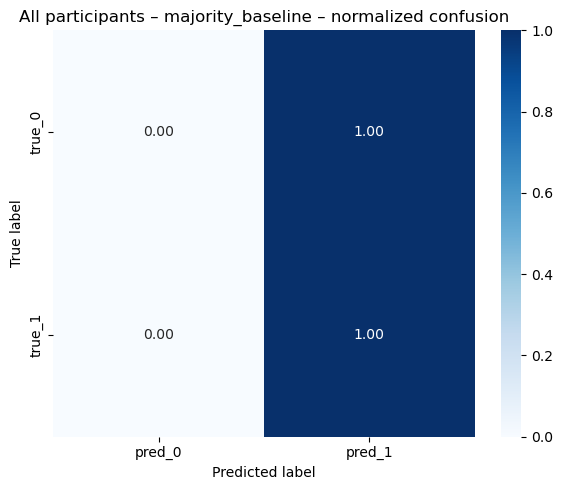

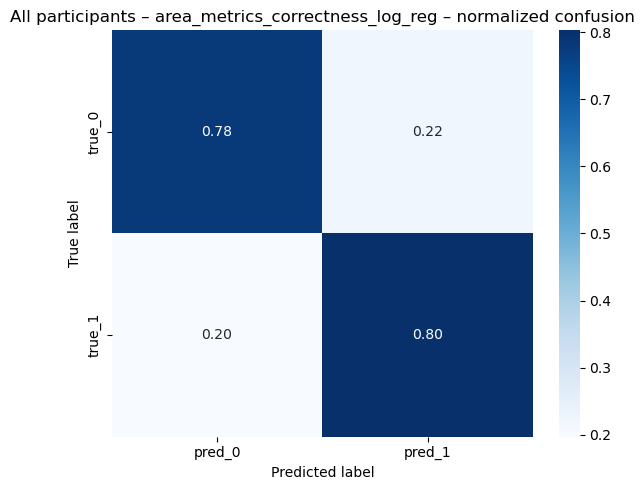

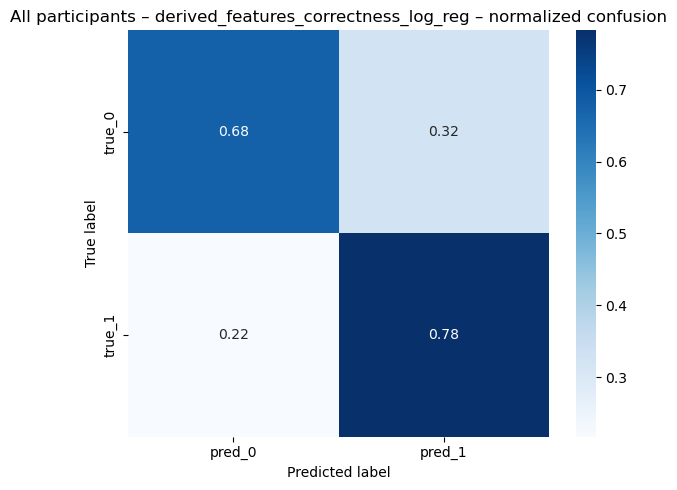

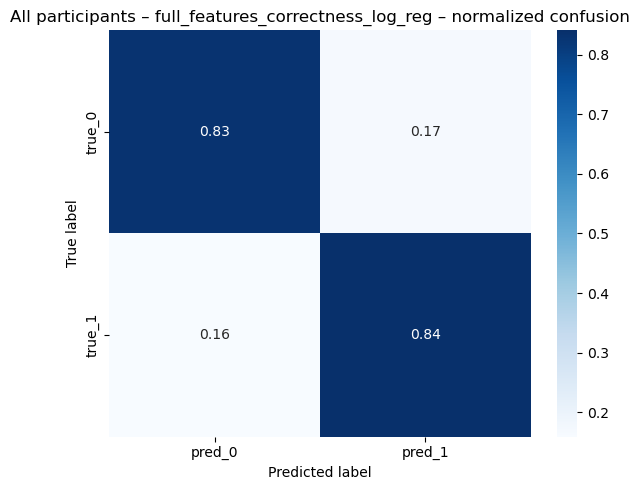

In [6]:
for name, res in results_all_corr_full.items():
    fig, cm_df, paths = plot_confusion_heatmap(
        y_true=res.y_true,
        y_pred=res.y_pred,
        labels=(0, 1),
        normalize=True,
        title=f"All participants – {name} – normalized confusion",
        save=True,
        rel_dir="answer_correctness/confusion/all_participants",
        filename=f"{name}_normalized_confusion",
        paper_dirs=["papers/correctness_prediction/figures"],
        close=False,
    )

                                       feature      coef  odds_ratio  \
0              area_dwell_proportion__answer_A  0.909518    2.483126   
1          mean_avg_fix_pupil_size_z__answer_A -0.815371    0.442475   
2          mean_avg_fix_pupil_size_z__answer_D -0.712268    0.490530   
3          mean_max_fix_pupil_size_z__answer_A  0.430270    1.537673   
4          mean_min_fix_pupil_size_z__answer_A  0.405575    1.500165   
5          mean_avg_fix_pupil_size_z__answer_C -0.375119    0.687208   
6                     num_loc_visits__answer_B -0.347032    0.706783   
7                   num_label_visits__answer_B -0.347032    0.706783   
8          mean_max_fix_pupil_size_z__answer_B -0.332782    0.716927   
9                   num_label_visits__answer_A  0.303815    1.355018   
10                    num_loc_visits__answer_A  0.303815    1.355018   
11         mean_max_fix_pupil_size_z__answer_D  0.295017    1.343149   
12         mean_min_fix_pupil_size_z__question  0.278111    1.32

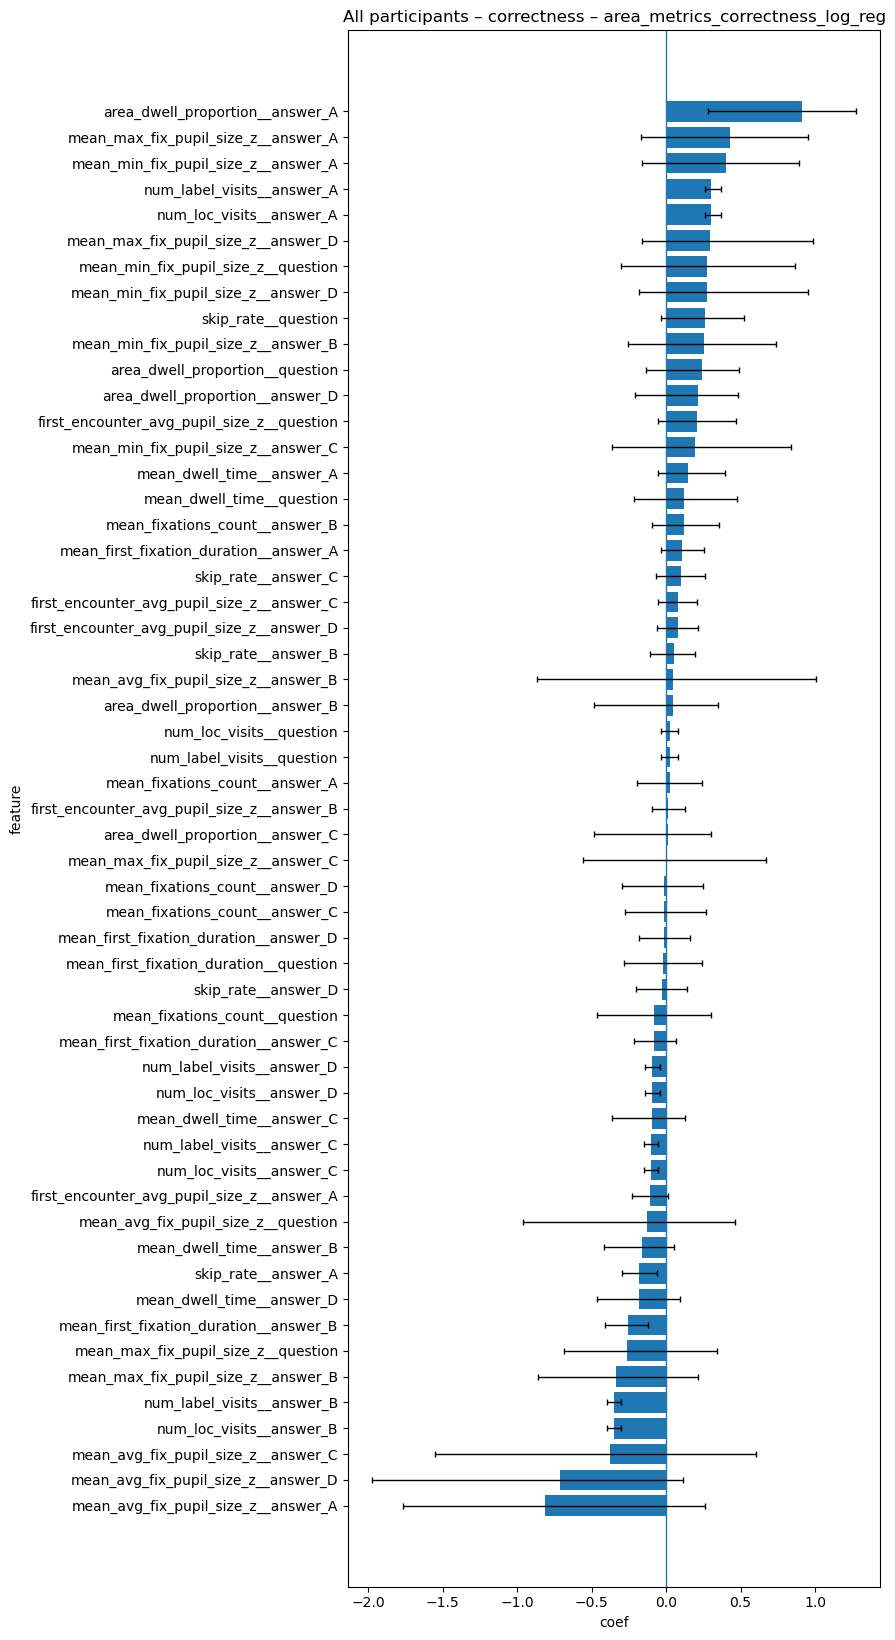

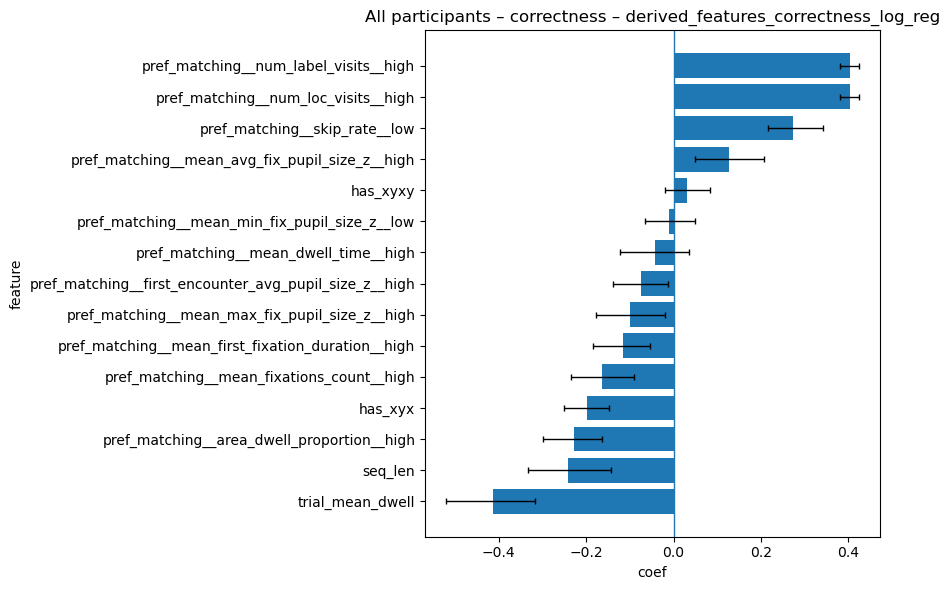

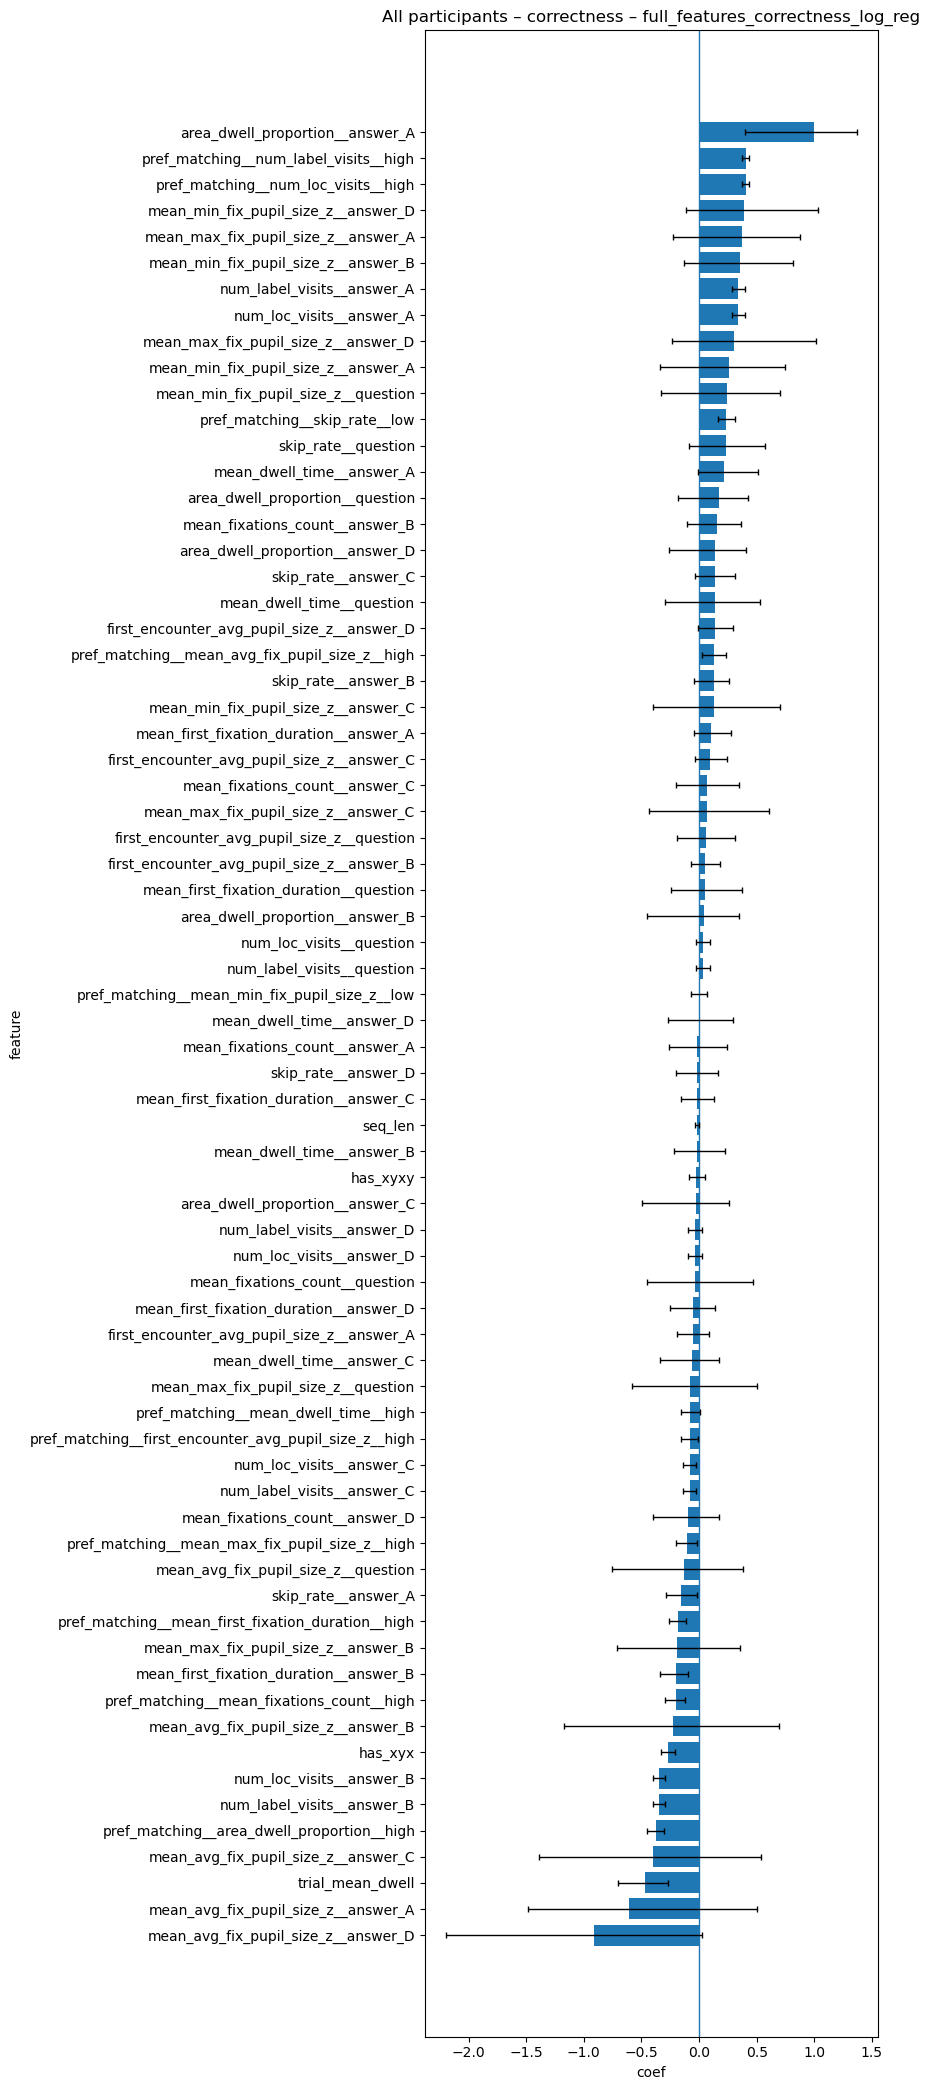

In [7]:
for model_name, res in results_all_corr_full.items():
    if res.coef_summary is None or res.coef_summary.empty:
        continue
    print(res.coef_summary)
    fig, plotted_df, paths = plot_coef_summary_barh(
        coef_summary=res.coef_summary,
        value_col="coef",
        model_name=model_name,
        title=f"All participants – correctness – {model_name}",
        save=True,
        rel_dir="answer_correctness/coefficients/all_participants",
        filename=f"{model_name}_all_participants_top75_coef",
        paper_dirs=PAPER_DIRS,
        dpi=300,
        close=False,
    )

    #new participant, new item


In [11]:
results_by_pid = evaluate_models_on_answer_correctness_leave_one_trial_out(
    df=all_participants,
    models=correctness_models,
    group_cols=(Con.PARTICIPANT_ID, Con.TRIAL_ID),
    builder_fn=build_trial_df,
)

In [11]:
base_out = "../reports/plots/participent_correctness_coeffs"
for pid, per_model in results_by_pid.items():
    for model_name, res in per_model.items():
        if res.coef_summary is None or res.coef_summary.empty:
            continue

        fig, plotted_df, paths = plot_coef_summary_barh(
            coef_summary=res.coef_summary,
            value_col="coef",
            model_name=model_name,
            title=f"Participant {pid} – correctness – {model_name}",
            save=True,
            rel_dir=f"answer_correctness/coefficients/per_participant/{model_name}",
            filename=f"{pid}_top75_coef",
            paper_dirs=PAPER_DIRS,
            dpi=300,
            close=True,
        )

,feature,count,n_pos,n_neg,n_zero,total_occ,prop,sign_varies,majority_sign,minority_count
24,mean_min_fix_pupil_size_z__answer_C,1,1,0,0,1,0.002809,False,1,0
25,mean_min_fix_pupil_size_z__answer_D,1,0,1,0,1,0.002809,False,-1,0
18,mean_first_fixation_duration__question,1,0,1,0,1,0.002809,False,-1,0
21,mean_max_fix_pupil_size_z__answer_A,1,0,1,0,1,0.002809,False,-1,0
11,mean_dwell_time__answer_A,1,0,1,0,1,0.002809,False,-1,0
8,first_encounter_avg_pupil_size_z__question,1,1,0,0,1,0.002809,False,1,0
45,trial_mean_dwell,1,0,1,0,1,0.002809,False,-1,0
44,skip_rate__question,1,1,0,0,1,0.002809,False,1,0
27,num_label_visits__question,1,0,1,0,1,0.002809,False,-1,0
23,mean_min_fix_pupil_size_z__answer_A,1,0,1,0,1,0.002809,False,-1,0


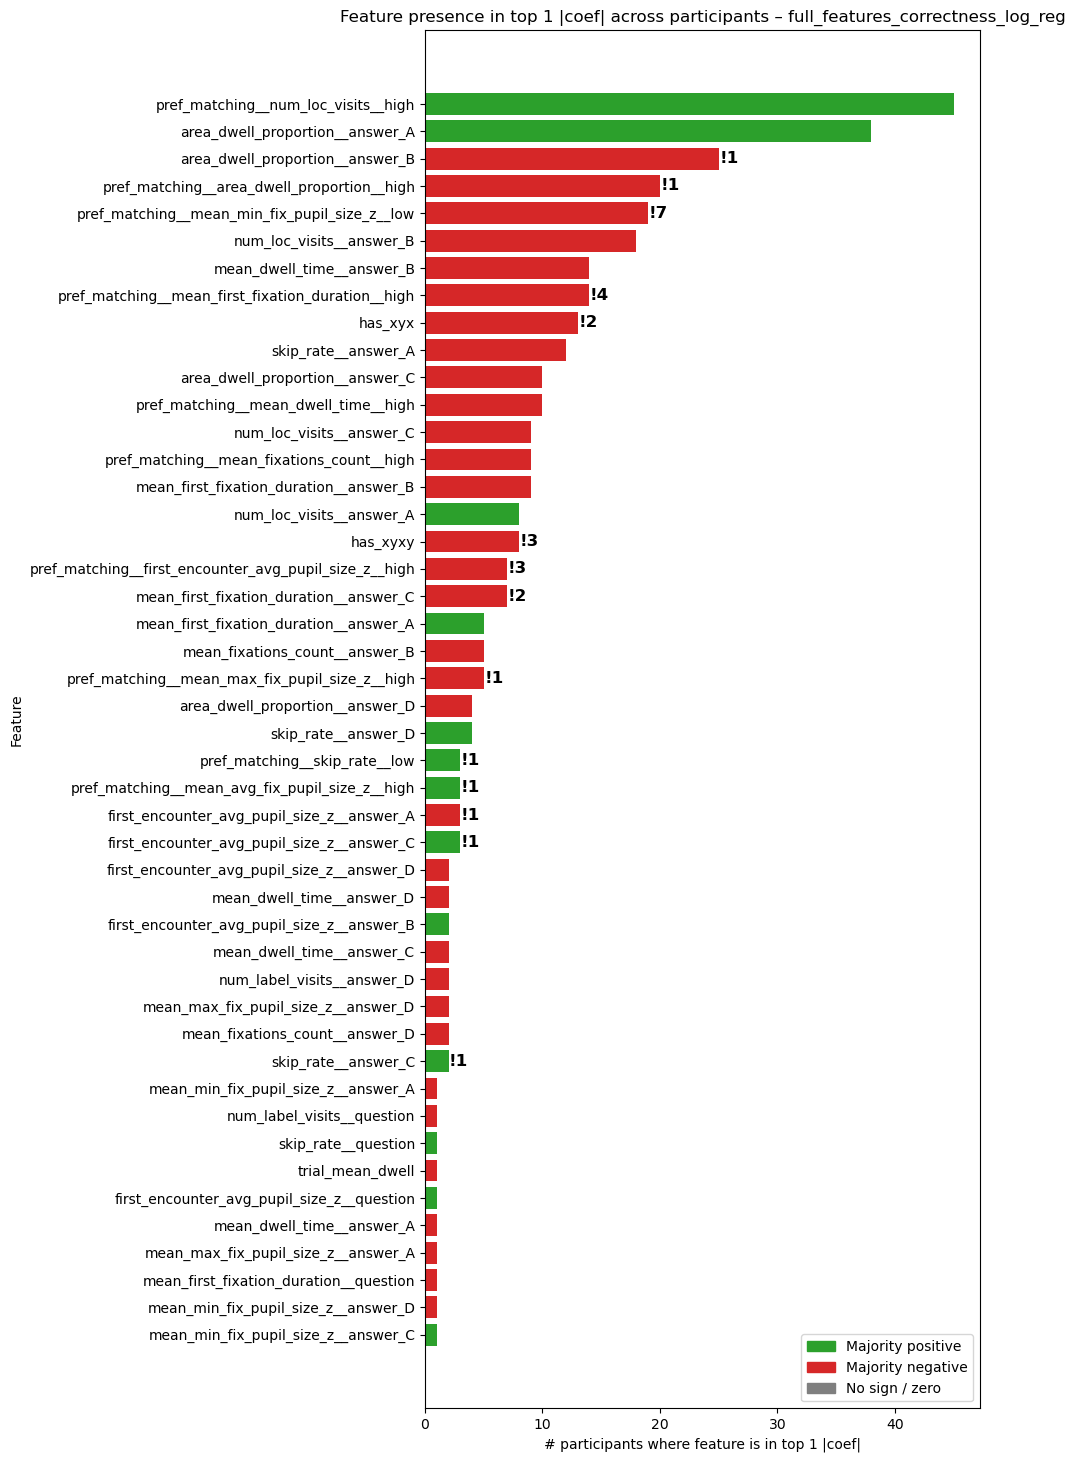

In [14]:
TOP_K_WITHIN_PARTICIPANT = 1
TOP_K_FEATURES_TO_SHOW = 70

fig, summary_df, paths = plot_top_abs_coef_feature_frequency_across_participants(
    results_by_pid=results_by_pid,
    model_name=MODEL_NAME_FOR_ANALYSIS,
    coef_col="coef",
    top_k_within_participant=TOP_K_WITHIN_PARTICIPANT,
    top_k_features=TOP_K_FEATURES_TO_SHOW,
    save=True,
    rel_dir="answer_correctness/coefficients/feature_presence",
    filename=f"top{TOP_K_WITHIN_PARTICIPANT}_presence_{MODEL_NAME_FOR_ANALYSIS}_top{TOP_K_FEATURES_TO_SHOW}",
    paper_dirs=PAPER_DIRS,
    dpi=300,
    close=False,
)
summary_df


,feature,count_participants,mean_rank,median_rank,std_rank,min_rank,max_rank
0,area_dwell_proportion__answer_A,356,17.275281,10.0,17.877913,1.0,70.0
60,pref_matching__num_label_visits__high,356,21.092697,14.5,19.739140,1.5,69.5
61,pref_matching__num_loc_visits__high,356,21.092697,14.5,19.739140,1.5,69.5
52,pref_matching__area_dwell_proportion__high,356,24.758427,18.0,20.079646,1.0,69.0
1,area_dwell_proportion__answer_B,356,25.688202,20.0,20.982782,1.0,70.0
2,area_dwell_proportion__answer_C,356,27.345506,25.0,19.992006,1.0,70.0
43,num_label_visits__answer_B,356,27.598315,24.0,19.868693,1.5,69.5
48,num_loc_visits__answer_B,356,27.598315,24.0,19.868693,1.5,69.5
64,skip_rate__answer_A,356,28.050562,23.0,20.578335,1.0,70.0
42,num_label_visits__answer_A,356,29.306180,26.5,19.955982,1.5,69.5


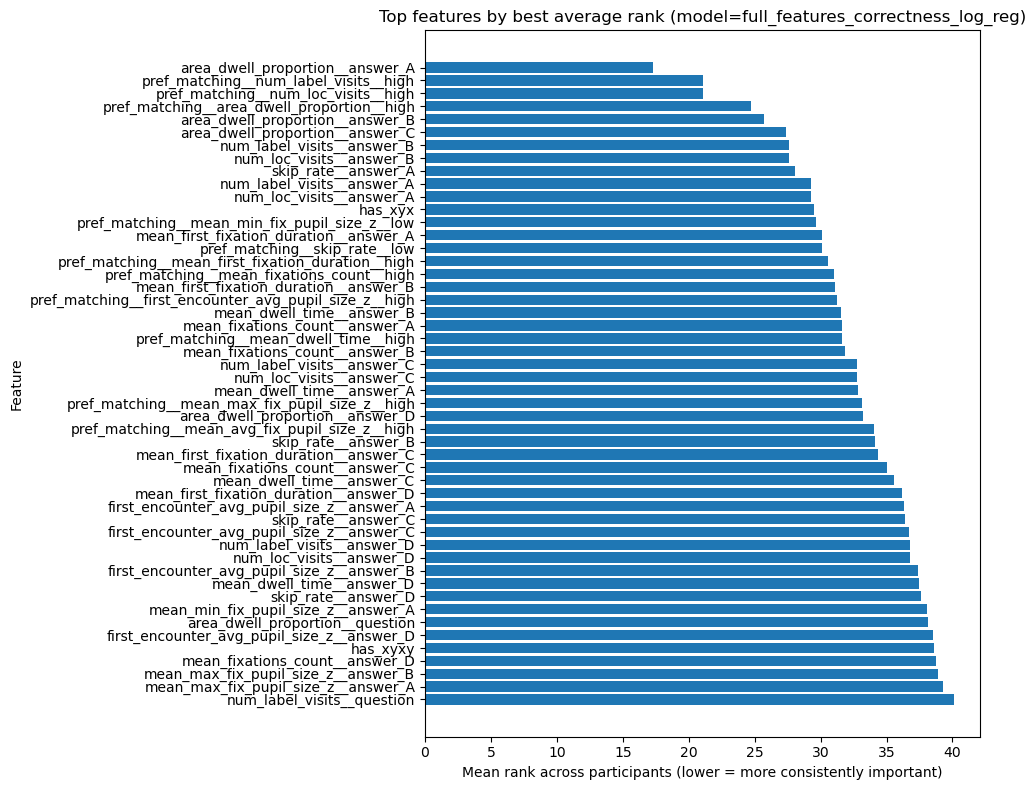

In [15]:
AVG_RANK_MIN_PARTICIPANTS = 1

avg_rank_df = compute_feature_avg_rank_across_participants(
    results_by_pid=results_by_pid,
    model_name=MODEL_NAME_FOR_ANALYSIS,
    coef_col="coef",
    abs_col="abs_coef",
)


fig_rank, df_plot, paths_rank = plot_top_features_by_best_avg_rank(
    avg_rank_df,
    top_k=50,
    min_participants=AVG_RANK_MIN_PARTICIPANTS,
    title=f"Top features by best average rank (model={MODEL_NAME_FOR_ANALYSIS})",
    save=True,
    rel_dir="answer_correctness/coefficients/avg_rank",
    filename=f"top_mean_ranks_{MODEL_NAME_FOR_ANALYSIS}_top50_minP{AVG_RANK_MIN_PARTICIPANTS}",
    paper_dirs=PAPER_DIRS,
    dpi=300,
    close=False,
)

avg_rank_df.head(30)


In [16]:
trial_df = build_trial_df(all_participants, group_cols=(Con.PARTICIPANT_ID, Con.TRIAL_ID))


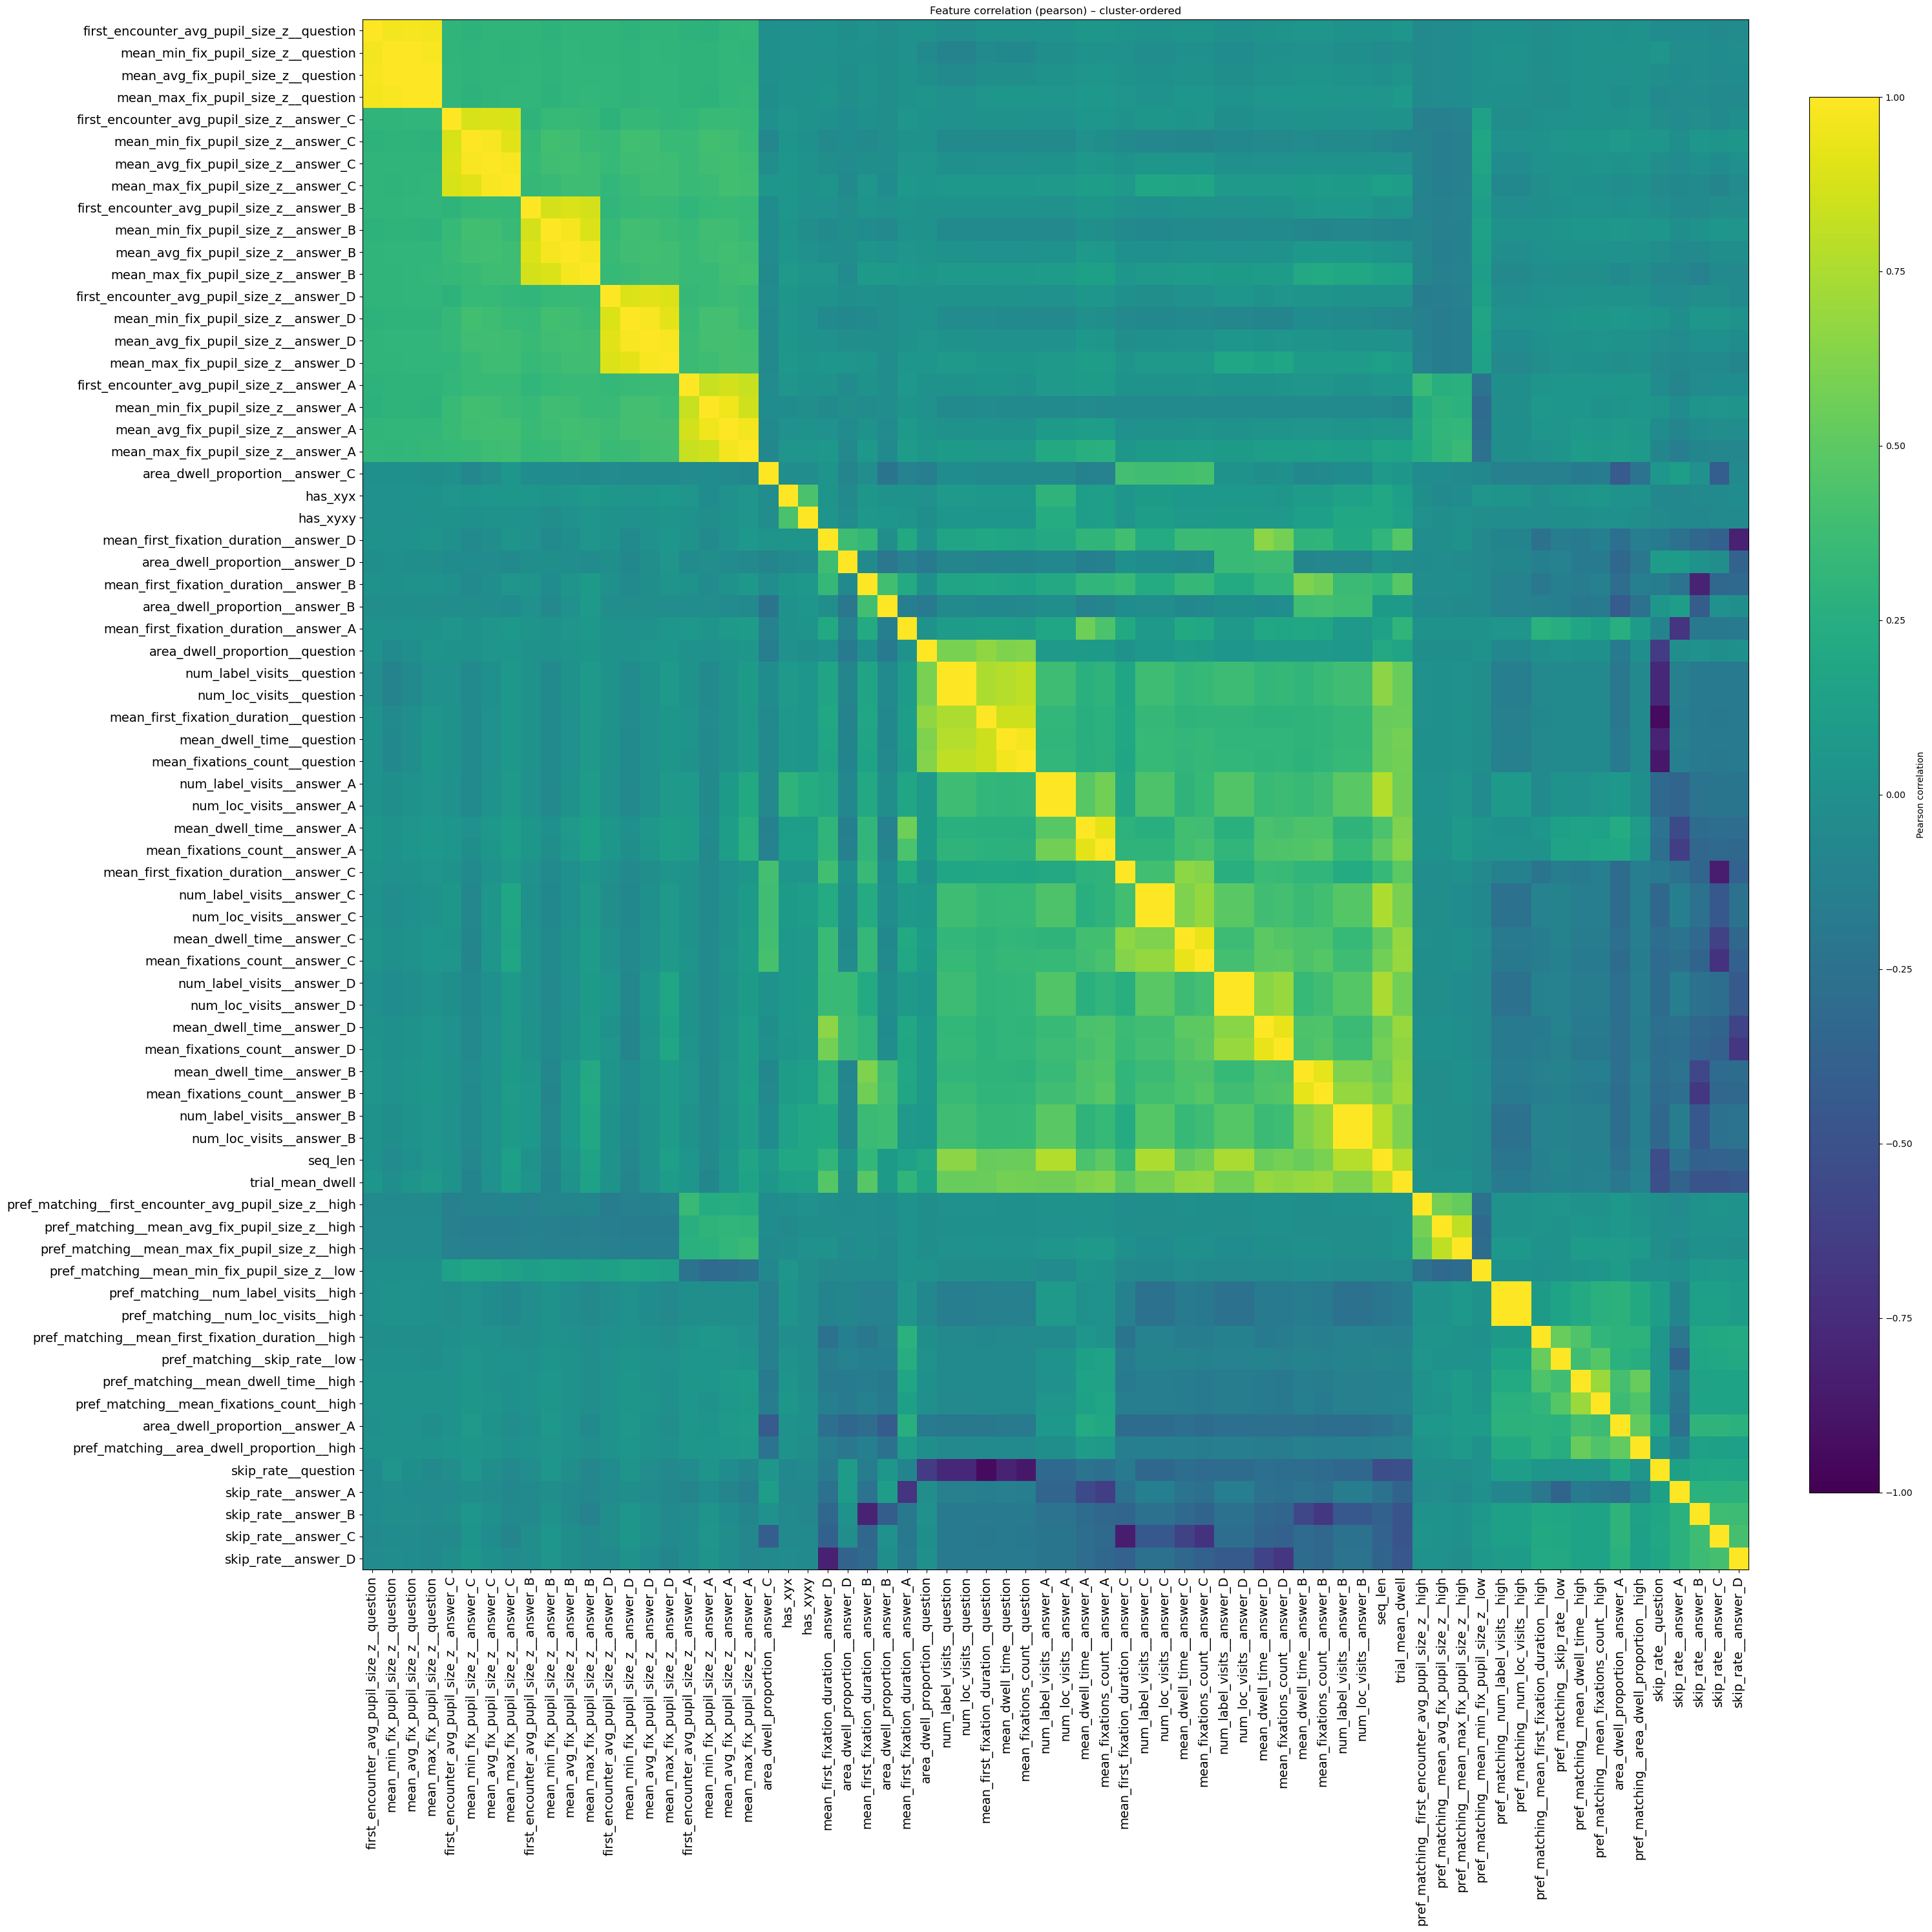

In [17]:
tmp = FullFeaturesCorrectnessLogRegModel()
feature_cols = tmp._build_feature_cols(trial_df)
selected_features = [
    "skip_rate__answer_A",
    "mean_dwell_time__answer_A",
    "skip_rate__answer_B",
    "mean_dwell_time__answer_B",
    "skip_rate__answer_C",
    "mean_dwell_time__answer_C",
    "skip_rate__answer_D",
    "mean_dwell_time__answer_D",

]


fig_corr, corr_df, paths_corr = plot_feature_correlation_heatmap(
    trial_df,
    feature_cols=feature_cols,
    figsize=(30, 30),
    method="pearson",
    cluster_order=True,
    save=True,
    rel_dir="answer_correctness/diagnostics/feature_correlation",
    filename=f"feature_corr_pearson_clustered_fullfeatures_n{len(feature_cols)}",
    paper_dirs=PAPER_DIRS,
    dpi=300,
    close=False,
)


### Clusters

In [ ]:


from src.predictive_modeling.answer_correctness.clusters.answer_correctness_participant_similarity import (
    build_participant_clustering_inputs,
    build_participant_family_clustering_inputs,
    default_feature_families,
)
from src.predictive_modeling.answer_correctness.clusters.answer_correctness_participant_cluster_metrics import (
    compute_distance_matrix,
    evaluate_k_range_silhouette,
    evaluate_k_range_davies_bouldin,
    cophenetic_correlation,
)
from src.predictive_modeling.answer_correctness.clusters.answer_correctness_participant_clusters_viz import (
    hierarchical_cluster_participants,
    plot_participant_dendrogram,
    compute_participant_umap,
    plot_participant_umap,
)
from src.predictive_modeling.answer_correctness.clusters.answer_correctness_participant_similarity_centroids import (
    compute_cluster_centroids,
    plot_cluster_centroids_barh,
)


In [14]:
def run_cluster_goodness_suite(
    X: pd.DataFrame,
    *,
    metric: str = "cosine",
    linkage_method: str = "average",
    k_range: range = range(2, 11),
):
    sil_df = evaluate_k_range_silhouette(
        X, distance_metric=metric, linkage_method=linkage_method, k_range=k_range
    )
    db_df = evaluate_k_range_davies_bouldin(
        X, linkage_method=linkage_method, k_range=k_range, normalize_rows_l2=True
    )
    D = compute_distance_matrix(X, metric=metric)
    coph = cophenetic_correlation(D, linkage_method=linkage_method)

    print(sil_df)
    print(db_df)
    print("cophenetic correlation:", coph)

    return sil_df, db_df, coph

    k  silhouette
0   2    0.054926
1   3    0.039122
2   4    0.036550
3   5    0.036225
4   6    0.033537
5   7    0.032722
6   8    0.032341
7   9    0.033850
8  10    0.035440
    k  davies_bouldin
0   2        5.582666
1   3        4.928689
2   4        4.578536
3   5        4.298001
4   6        4.183851
5   7        3.942137
6   8        3.824529
7   9        3.702883
8  10        3.568305
cophenetic correlation: 0.3273193649749456


C:\Users\deeth\miniconda3\envs\QA_eyetracking_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


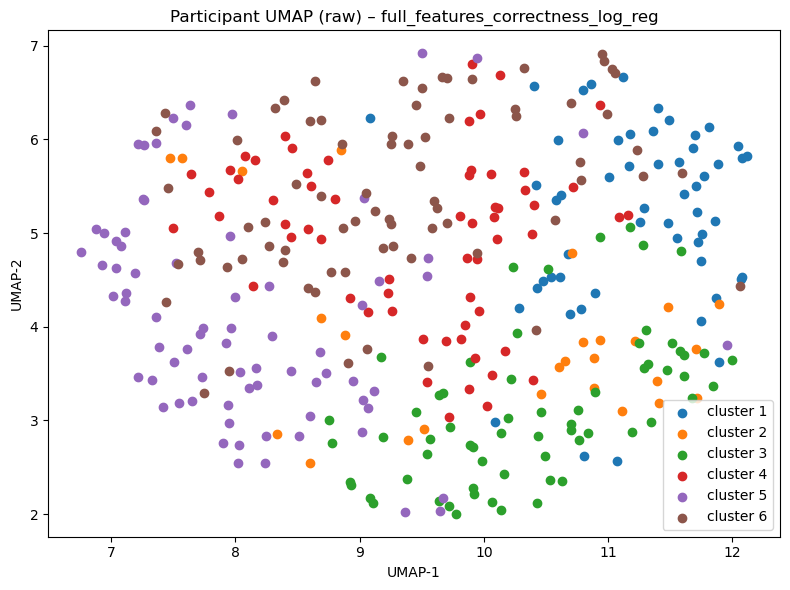

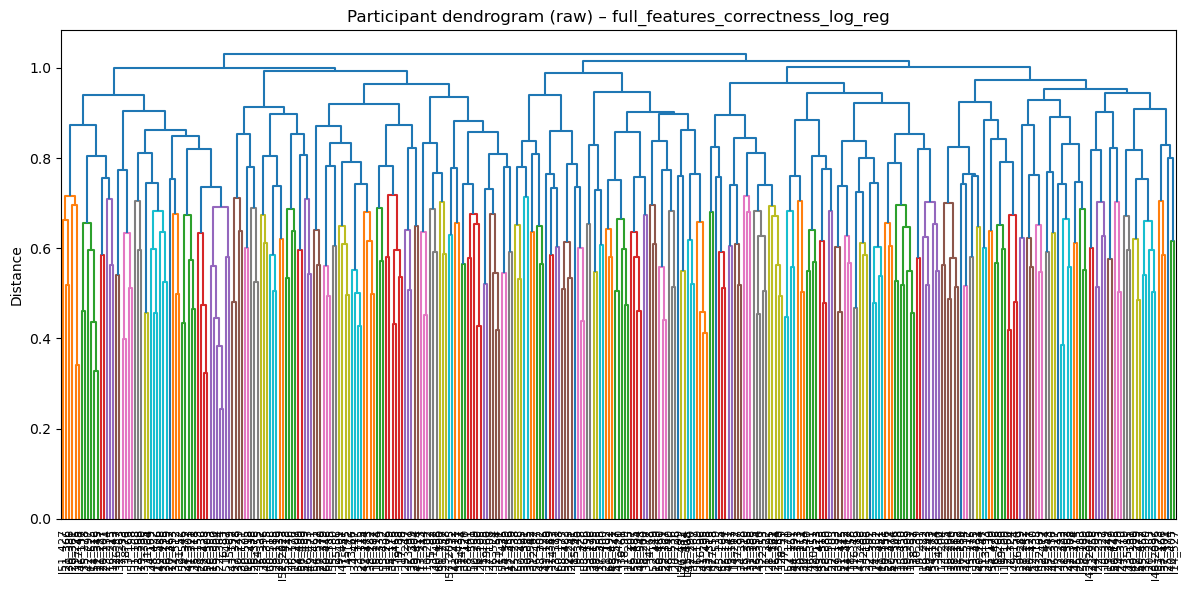

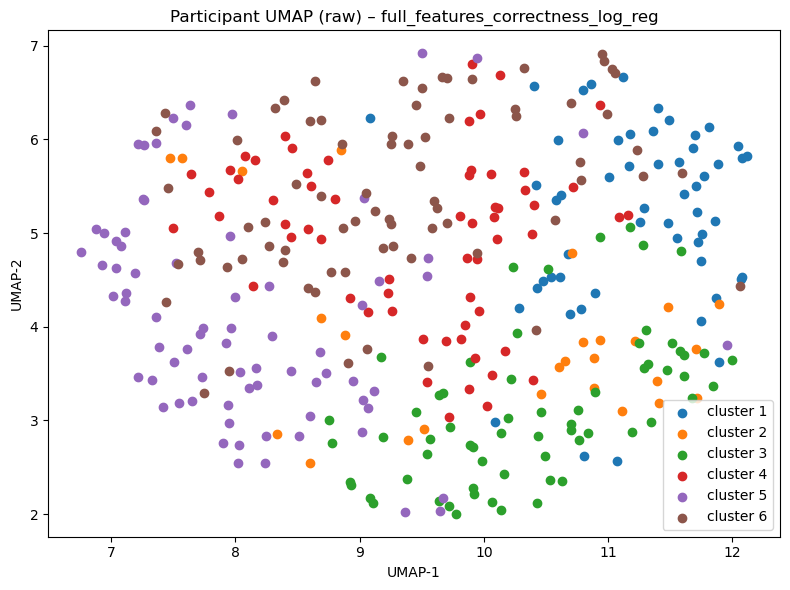

In [15]:
#  Participant similarity (raw coefficient vectors)
model_name = MODEL_NAME_FOR_ANALYSIS

inputs_raw = build_participant_clustering_inputs(
    results_by_pid=results_by_pid,
    model_name=model_name,
    coef_col="coef",
    zscore=True,
)

# --- goodness checks
run_cluster_goodness_suite(inputs_raw.coef_matrix_z)

# --- clustering + plots
D_raw = compute_distance_matrix(inputs_raw.coef_matrix_z, metric="cosine")
clust_raw = hierarchical_cluster_participants(
    D_raw, linkage_method="average", cut_mode="n_clusters", n_clusters=6
)

out_dir_raw = f"../reports/plots/participant_similarity/correctness/{model_name}/raw"
plot_participant_dendrogram(
    clust_raw,
    title=f"Participant dendrogram (raw) – {model_name}",
    save_path=os.path.join(out_dir_raw, "dendrogram.png"),
)

umap_xy_raw = compute_participant_umap(inputs_raw.coef_matrix_z, metric="cosine")
plot_participant_umap(
    umap_xy_raw,
    labels=clust_raw.labels,
    title=f"Participant UMAP (raw) – {model_name}",
    save_path=os.path.join(out_dir_raw, "umap.png"),
)

    k  silhouette
0   2    0.233956
1   3    0.183946
2   4    0.146629
3   5    0.154979
4   6    0.178229
5   7    0.161457
6   8    0.176380
7   9    0.159647
8  10    0.177492
    k  davies_bouldin
0   2        2.353728
1   3        2.105717
2   4        1.990995
3   5        2.098715
4   6        1.997960
5   7        1.894398
6   8        1.855276
7   9        1.693528
8  10        1.637747
cophenetic correlation: 0.5157470887501305


C:\Users\deeth\miniconda3\envs\QA_eyetracking_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


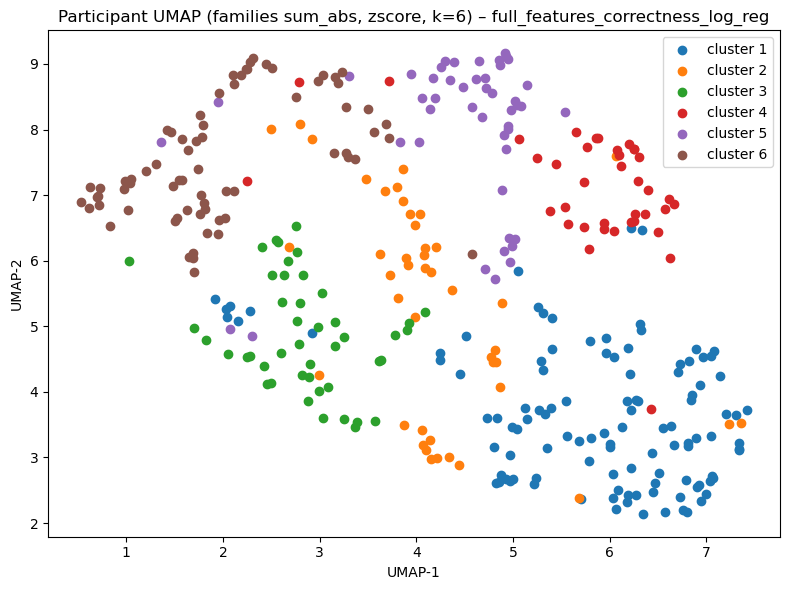

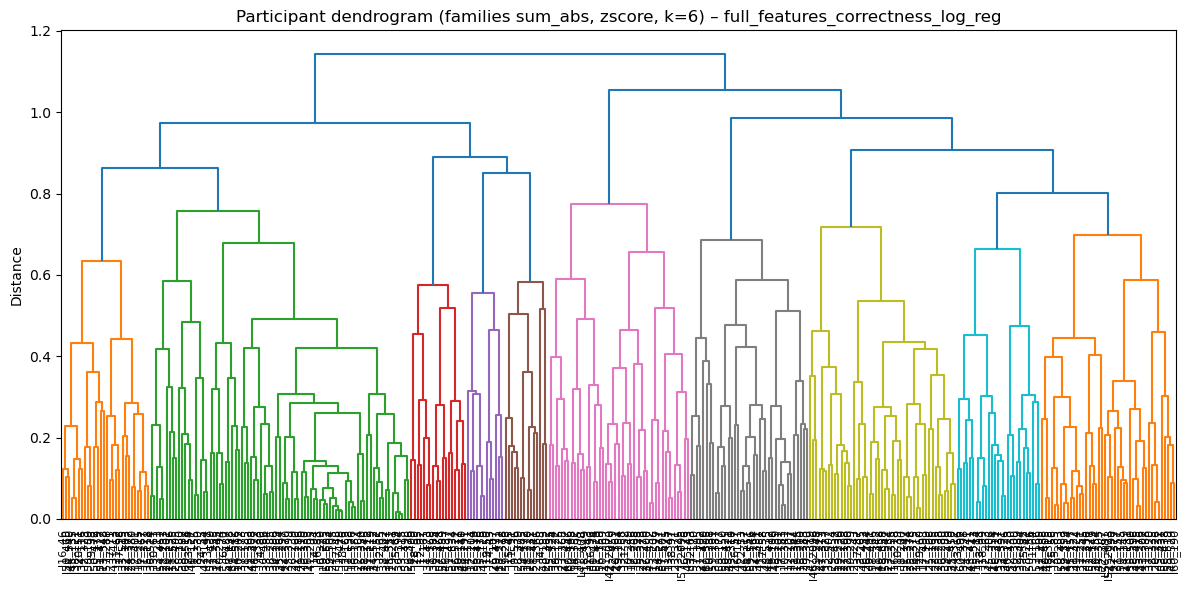

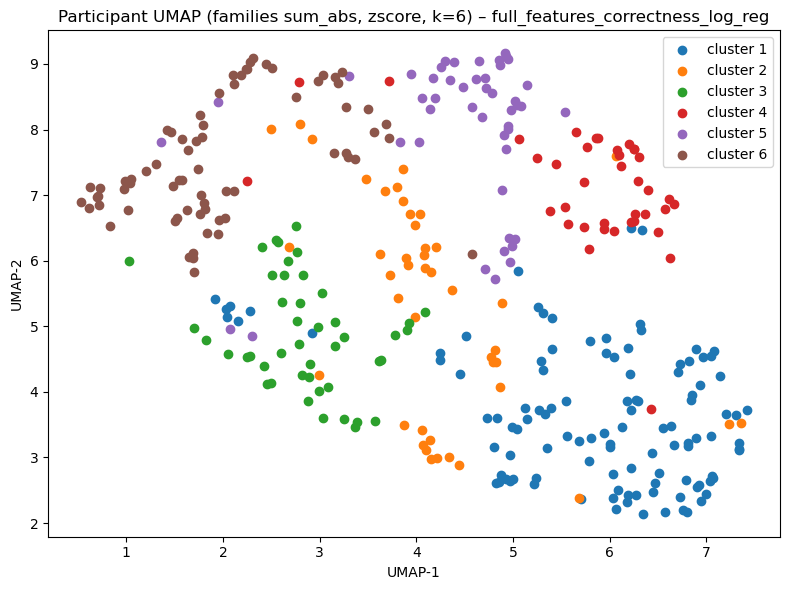

In [16]:
# Participant similarity (family-aggregated coefficient vectors)
fam_agg = "sum_abs"
zscore_flag = True
n_clusters = 6

z_tag = "zscore" if zscore_flag else "noz"
k_tag = f"k{n_clusters}"

fam_inputs = build_participant_family_clustering_inputs(
    results_by_pid=results_by_pid,
    model_name=model_name,
    coef_col="coef",
    families=default_feature_families(),
    family_agg=fam_agg,
    zscore=zscore_flag,
)

# --- goodness checks
run_cluster_goodness_suite(fam_inputs.coef_matrix_z)

# --- clustering + plots
D_fam = compute_distance_matrix(fam_inputs.coef_matrix_z, metric="cosine")

clust_fam = hierarchical_cluster_participants(
    D_fam,
    linkage_method="average",
    cut_mode="n_clusters",
    n_clusters=n_clusters,
)

out_dir_fam = (
    f"../reports/plots/participant_similarity/"
    f"correctness/{model_name}/"
    f"families_{fam_agg}_{z_tag}_{k_tag}"
)

os.makedirs(out_dir_fam, exist_ok=True)
plot_participant_dendrogram(
    clust_fam,
    title=(
        f"Participant dendrogram "
        f"(families {fam_agg}, {z_tag}, k={n_clusters}) – {model_name}"
    ),
    save_path=os.path.join(out_dir_fam, "dendrogram.png"),
)

umap_xy_fam = compute_participant_umap(
    fam_inputs.coef_matrix_z,
    metric="cosine",
)

plot_participant_umap(
    umap_xy_fam,
    labels=clust_fam.labels,
    title=(
        f"Participant UMAP "
        f"(families {fam_agg}, {z_tag}, k={n_clusters}) – {model_name}"
    ),
    save_path=os.path.join(out_dir_fam, "umap.png"),
)

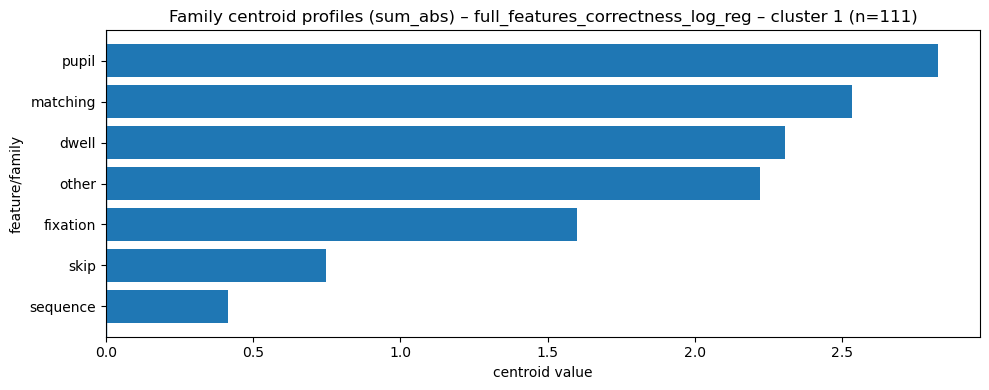

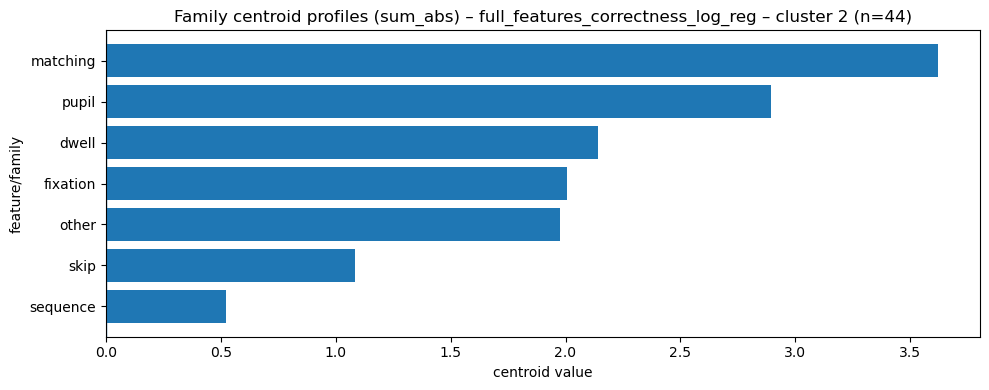

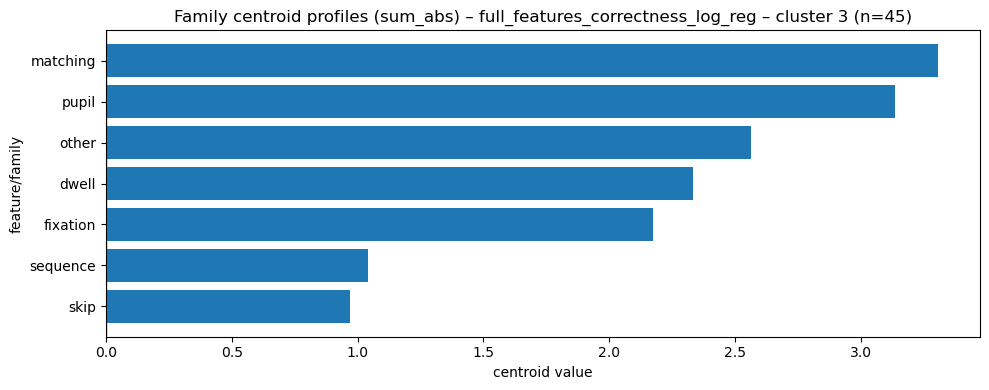

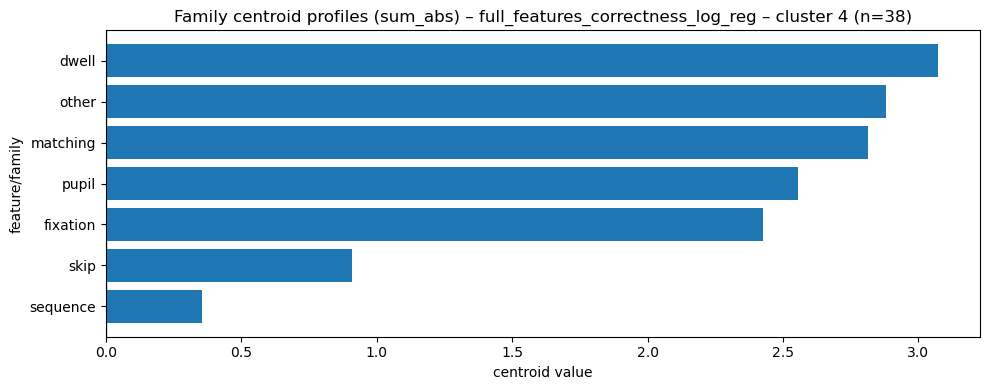

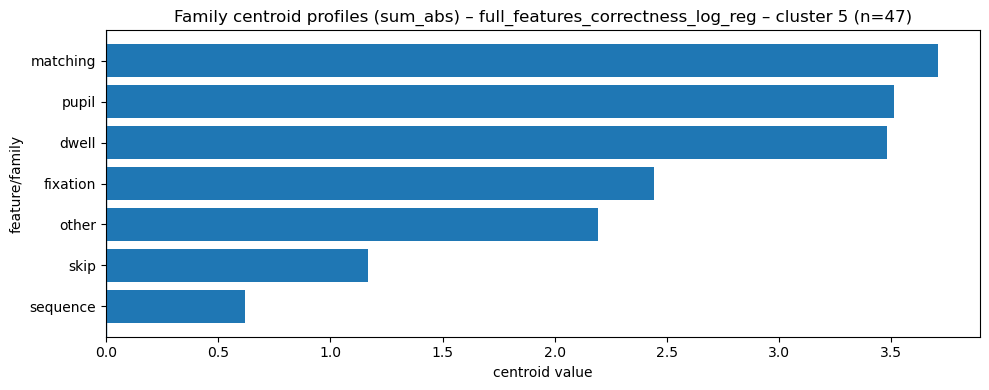

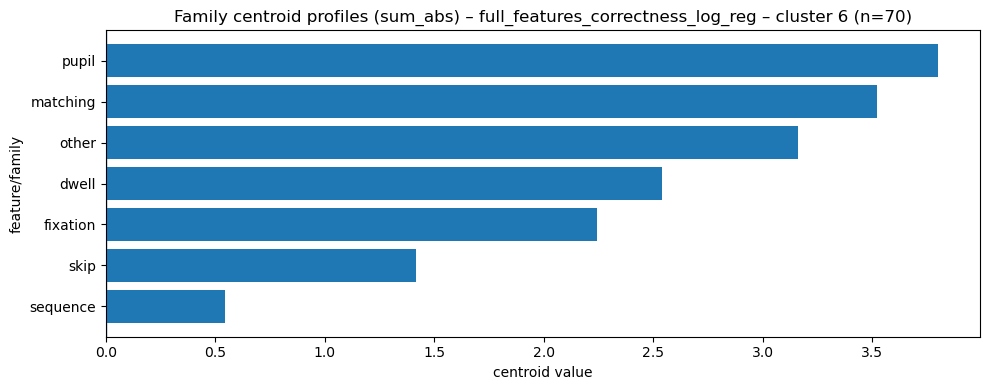

In [17]:
X_fam = fam_inputs.coef_matrix

cent_res = compute_cluster_centroids(
    X=X_fam,
    labels=clust_fam.labels,
    agg="mean",
    top_k=10,
)

# # Save centroid tables for inspection
# cent_res.centroids.to_csv(os.path.join(out_dir_fam, "cluster_centroids.csv"))
# cent_res.counts.to_csv(os.path.join(out_dir_fam, "cluster_sizes.csv"))
# cent_res.top_features.to_csv(os.path.join(out_dir_fam, "cluster_top_features.csv"), index=False)

# Plot one centroid bar chart per cluster
plot_cluster_centroids_barh(
    centroids=cent_res.centroids,
    counts=cent_res.counts,
    top_k=12,
    title=f"Family centroid profiles ({fam_agg}) – {MODEL_NAME_FOR_ANALYSIS}",
    save_path=os.path.join(out_dir_fam, "centroid_cluster{cluster}.png"),
)

In [16]:
#beep boop